# IMPORTING LIBRARIES

In [1]:
# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

pd.options.display.max_rows = 100
# plt.rcParams['figure.figsize'] = (16,12)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.__version__

'1.18.1'

# Fonctions d'automatisation 

In [2]:
# retourne un tableau qui nous donne les valeurs manquantes de chaque colonne et leurs pourcentages
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() * 100 /
               df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent],
                             axis=1,
                             keys=['données manquantes', '%_DM'])

    return missing_data


# --------------------------------------------------------------------------------------


# retourne la racine de l'erreur quadratique moyenne au carré ( RMSE) RootMeanSquared
def RMSE(X_test, y_test):
    rmse = (mean_squared_error(X_test, y_test))**1 / 2
    return rmse


# --------------------------------------------------------------------------------------


#fonction pour faire des distribution
def custom_displot(df, feature,feature_log,feature_sqrt):
        
    fig, axs = plt.subplots(ncols=3, figsize=(16, 6))
    
    sns.distplot(df[feature].dropna(), ax=axs[0],axlabel=feature+'(normal)')
    sns.distplot(feature_log.dropna(), ax=axs[1],axlabel=feature+'(log)')
    sns.distplot(feature_sqrt.dropna(), ax=axs[2],axlabel=feature+'(sqrt)')
    plt.tight_layout()

    return None


# --------------------------------------------------------------------------------------

# Retourne une liste avec seulement les colonnes qui ont un % de données manquantes < ( un certain % qu'on lui donnera )

def select_columns(df, col, max_to_keep):
    list_columns_names = []
    new_df = df[df[col] <= max_to_keep]
    for i in range(len(new_df.index)):
        list_columns_names.append(new_df.index[i])
    return list_columns_names

#----------------------------------------------------------------------------------------

# Retourne 2 listes : numerique et categorique respectivement !

def get_num_categ_columns(df):
    num_cols = []
    cat_cols = []
    for column in df.columns:
        if df[column].dtypes == object:
            df[column] = df[column].astype(str)
            cat_cols.append(column)
        else:
            num_cols.append(column)
    return num_cols,cat_cols

#-----------------------------------------------------------------------------------------



# ANALYSE PRE-EXPLORATOIRE

In [3]:
#read data
data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv")
#----------------------------------------------------------------------------------------
# make 1 dataframe with concat method

data = pd.concat([data_2015, data_2016])
data.sample(3)
data.shape
#----------------------------------------------------------------------------------------

,2010 Census Tracts,Address,BuildingType,City,City Council Districts,Comment,Comments,ComplianceStatus,CouncilDistrictCode,DataYear,...,State,SteamUse(kBtu),TaxParcelIdentificationNumber,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,YearBuilt,YearsENERGYSTARCertified,Zip Codes,ZipCode
1518,NaN,NaN,Multifamily LR (1-4),NaN,NaN,NaN,NaN,Compliant,3,2015,...,NaN,0.0,2695200000,NaN,NaN,NaN,1929,NaN,19578.0,NaN
248,NaN,NaN,NonResidential,NaN,NaN,NaN,NaN,Compliant,7,2015,...,NaN,0.0,694000205,NaN,NaN,NaN,1979,NaN,19576.0,NaN
1567,NaN,NaN,Multifamily LR (1-4),NaN,NaN,NaN,NaN,Compliant,7,2015,...,NaN,0.0,2617550000,NaN,NaN,NaN,1984,NaN,18390.0,NaN


(6716, 56)

In [4]:
df = missing_data(data)
df.head(10)
df.tail(15)
data.info()


,données manquantes,%_DM
Comments,6716,100.000000
Comment,6703,99.806432
Outlier,6600,98.272781
City Council Districts,6503,96.828469
2010 Census Tracts,6492,96.664681
YearsENERGYSTARCertified,6487,96.590232
ThirdLargestPropertyUseTypeGFA,5560,82.787373
ThirdLargestPropertyUseType,5560,82.787373
SecondLargestPropertyUseTypeGFA,3478,51.786778
SecondLargestPropertyUseType,3478,51.786778


,données manquantes,%_DM
NumberofBuildings,8,0.119119
TaxParcelIdentificationNumber,2,0.029780
DefaultData,1,0.014890
OSEBuildingID,0,0.000000
PrimaryPropertyType,0,0.000000
PropertyGFABuilding(s),0,0.000000
Neighborhood,0,0.000000
CouncilDistrictCode,0,0.000000
ComplianceStatus,0,0.000000
PropertyGFAParking,0,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 56 columns):
2010 Census Tracts                                               224 non-null float64
Address                                                          3376 non-null object
BuildingType                                                     6716 non-null object
City                                                             3376 non-null object
City Council Districts                                           213 non-null float64
Comment                                                          13 non-null object
Comments                                                         0 non-null float64
ComplianceStatus                                                 6716 non-null object
CouncilDistrictCode                                              6716 non-null int64
DataYear                                                         6716 non-null int64
DefaultData                            

In [5]:
# select columns with less than 55% missing values automatic with custum function

selected_columns = select_columns(df,col='%_DM',max_to_keep=55)
#----------------------------------------------------------------------------------------

selected_columns.remove('PropertyName') 
# its not good to remove duplicate based on the name because we know that we have 2015 and 2016 data
#so its sure that there is duplicates and we need them because they have different values

#----------------------------------------------------------------------------------------

df2 = data[selected_columns].copy()

df2.shape
missing_data(df2)
df2.describe()

#----------------------------------------------------------------------------------------

(6716, 47)

,données manquantes,%_DM
SecondLargestPropertyUseTypeGFA,3478,51.786778
SecondLargestPropertyUseType,3478,51.786778
GHGEmissionsIntensity(kgCO2e/ft2),3386,50.416915
OtherFuelUse(kBtu),3386,50.416915
GHGEmissions(MetricTonsCO2e),3386,50.416915
SPD Beats,3378,50.297796
Seattle Police Department Micro Community Policing Plan Areas,3378,50.297796
Location,3376,50.268017
Zip Codes,3376,50.268017
ZipCode,3356,49.970220


,SecondLargestPropertyUseTypeGFA,GHGEmissionsIntensity(kgCO2e/ft2),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),SPD Beats,Seattle Police Department Micro Community Policing Plan Areas,Zip Codes,ZipCode,GHGEmissionsIntensity,TotalGHGEmissions,...,SiteEnergyUse(kBtu),NumberofFloors,NumberofBuildings,OSEBuildingID,PropertyGFABuilding(s),CouncilDistrictCode,PropertyGFAParking,YearBuilt,PropertyGFATotal,DataYear
count,3238.000000,3330.000000,3.330000e+03,3330.000000,3338.000000,3338.000000,3340.000000,3360.000000,3367.000000,3367.000000,...,6.701000e+03,6708.000000,6708.000000,6716.000000,6.716000e+03,6716.000000,6716.000000,6716.000000,6.716000e+03,6716.00000
mean,28074.100153,0.985339,7.142301e+03,110.094102,24.825644,32.380168,18786.680240,98116.949107,1.175916,119.723971,...,5.194673e+06,4.695736,1.071407,20867.420488,8.329450e+04,4.445057,9519.597975,1968.101549,9.281410e+04,2015.50268
std,53473.984688,1.637172,1.962790e+05,409.450179,15.006287,19.907567,588.604192,18.615205,1.821452,538.832227,...,1.813648e+07,5.476218,1.593505,11878.968174,1.733470e+05,2.123749,33868.050881,33.020391,1.875062e+05,0.50003
min,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,17916.000000,98006.000000,-0.020000,-0.800000,...,0.000000e+00,0.000000,0.000000,1.000000,-5.055000e+04,1.000000,-3.000000,1900.000000,1.128500e+04,2015.00000
25%,4993.000000,0.080000,0.000000e+00,9.265000,10.000000,14.000000,18379.000000,98105.000000,0.210000,9.495000,...,9.200689e+05,2.000000,1.000000,19934.000000,2.727300e+04,3.000000,0.000000,1948.000000,2.848700e+04,2015.00000
50%,10631.000000,0.460000,0.000000e+00,32.740000,26.000000,33.000000,18390.000000,98115.000000,0.610000,33.920000,...,1.791071e+06,4.000000,1.000000,23064.000000,4.218500e+04,4.000000,0.000000,1974.000000,4.400800e+04,2016.00000
75%,26462.000000,1.180000,0.000000e+00,88.642500,38.000000,50.000000,19576.000000,98122.000000,1.370000,93.940000,...,4.135280e+06,5.000000,1.000000,25868.250000,8.112000e+04,7.000000,0.000000,1996.000000,8.943125e+04,2016.00000
max,686750.000000,31.380000,8.269669e+06,11824.890000,51.000000,61.000000,19584.000000,98272.000000,34.090000,16870.980000,...,8.739237e+08,99.000000,111.000000,50226.000000,9.320156e+06,7.000000,512608.000000,2015.000000,9.320156e+06,2016.00000


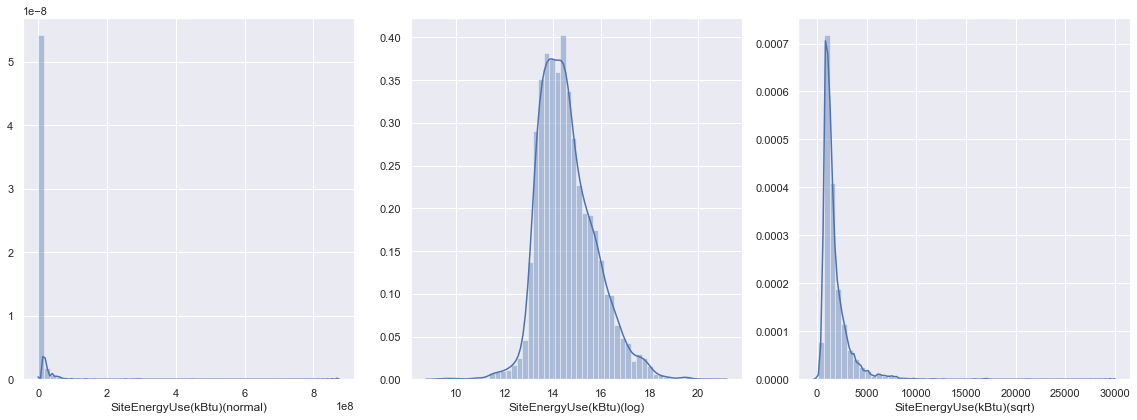

In [6]:
# we only have 20 values/6700 so we can replace them with the mean, then we can use Log or Sqrt
sns.set(rc={'figure.figsize':(11.7,8.27)})
df2['SiteEnergyUse(kBtu)'].replace(
    0, df2['SiteEnergyUse(kBtu)'].mean(), inplace=True)

#------------------------------------------------------------------------------------------------------

# visualisation la difference entre la racine et le log de la target electricity

custom_displot(df2,
               feature='SiteEnergyUse(kBtu)',
               feature_log=np.log(df2['SiteEnergyUse(kBtu)']),
               feature_sqrt=np.sqrt(df2['SiteEnergyUse(kBtu)']))

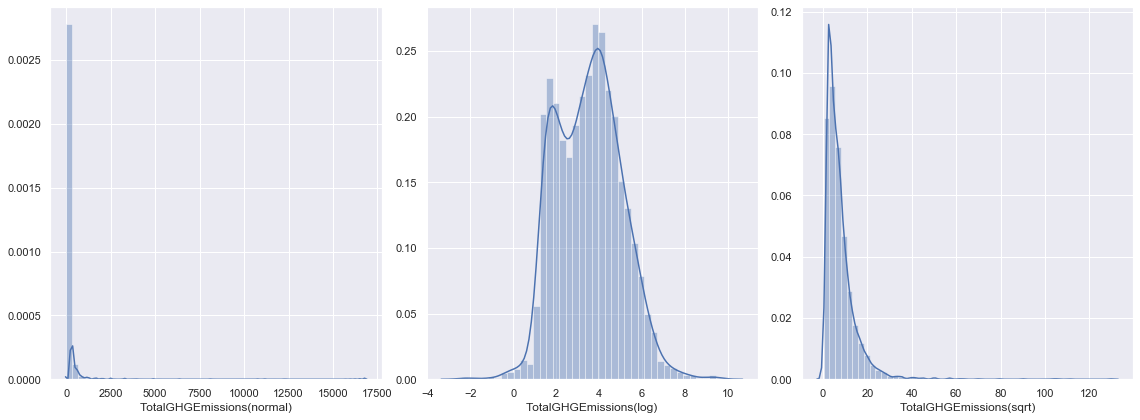

In [7]:
# we only have 2 values/6700 so we can replace them with the mean, then we can use Log or Sqrt

df2['TotalGHGEmissions'].replace(
    0, df2['TotalGHGEmissions'].mean(), inplace=True)

df2['TotalGHGEmissions'].replace(
    -0.80, df2['TotalGHGEmissions'].mean(), inplace=True)

#----------------------------------------------------------------------------------------

# Visualisation ghgemissions normal,log,sqrt

custom_displot(df2,
               feature='TotalGHGEmissions',
               feature_log=np.log(df2['TotalGHGEmissions']),
               feature_sqrt=np.sqrt(df2['TotalGHGEmissions']))

#----------------------------------------------------------------------------------------

In [8]:
# Get Numerical and categorical columns
num_cols, cat_cols = get_num_categ_columns(df2)

print("we have:", len(cat_cols), "categorical columns")
print("we have:", len(num_cols), "numerical columns")


we have: 13 categorical columns
we have: 34 numerical columns


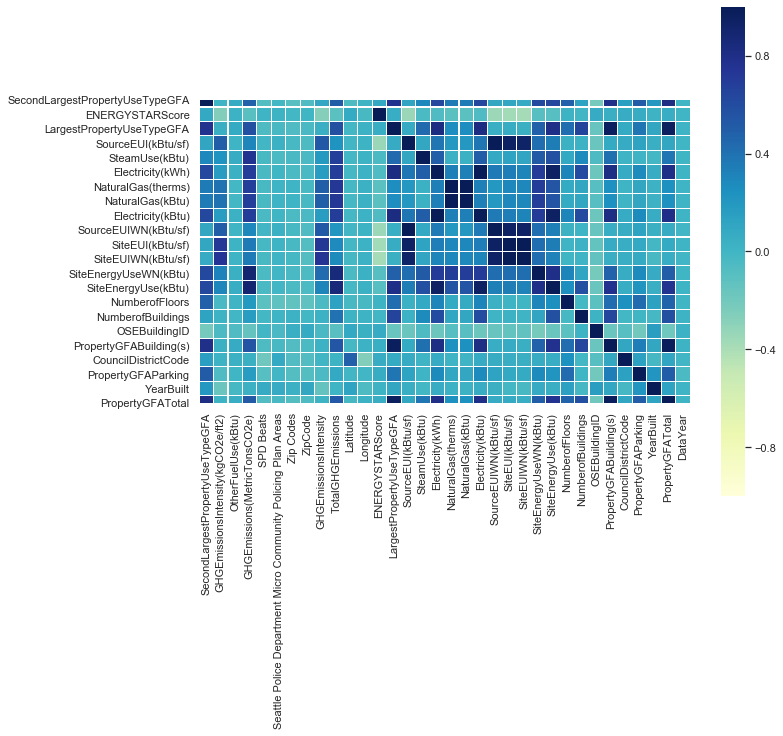

In [9]:
# Heatmap to see correlations 

corr = df2[num_cols].corr().dropna()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap 
# cmap = sns.diverging_palette(220, 10, as_cmap=True)            ### not working with Numpy >= 1.18.1 



# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='YlGnBu', vmax=1,vmin=-1, center=0,
            square=True, linewidths=.1)

### On notera que la consommation electrique et l'émission du CO2 sont trés correleés, ce qui va largement impacter nos prédictions si on laisse l'une de ces features dans le train

# Preprocessing et Feature engineering 

In [10]:
# keep Adress and Location processing for later
df3 = df2.drop(['Address', 'Location'], axis=1)

#----------------------------------------------------------------------------------------
df3[['DefaultData']] # to visualize

# correct 'DefaultData' column to get 0 and 1  later :
df3['DefaultData'].replace('True', 'Yes', inplace=True)
df3['DefaultData'].replace('False', 'No', inplace=True)

#----------------------------------------------------------------------------------------
# use Labelencoder for categorical colms 
le = LabelEncoder()

for column in cat_cols:
    if column in df3.columns:
        df3[column] = le.fit_transform(df3[column])
        
#----------------------------------------------------------------------------------------        

,DefaultData
0,No
1,No
2,Yes
3,No
4,No
...,...
3371,True
3372,False
3373,False
3374,False


In [11]:
# Create new feature by combining zipcodes columns :
df3['ZipCode'] = df3['ZipCode'].astype(str)
df3['Zip Codes'] = df3['Zip Codes'].astype(str)

df3['ZipCode'].replace('nan', "", inplace=True)
df3['Zip Codes'].replace('nan', "", inplace=True)

df3['zip_codes'] = df3['Zip Codes'] + df3['ZipCode']
df3['zip_codes'] = pd.to_numeric(df3['zip_codes'])
df3[['zip_codes','ZipCode','Zip Codes']].sample(10)
#----------------------------------------------------------------------------------------
#now we can drop the 2 columns :
df3.drop(['ZipCode', 'Zip Codes'], axis=1, inplace=True)


#----------------------------------------------------------------------------------------

,zip_codes,ZipCode,Zip Codes
2651,19578.0,,19578.0
1064,19576.0,,19576.0
2288,17919.0,,17919.0
2947,98126.0,98126.0,
2356,18388.0,,18388.0
2085,18795.0,,18795.0
3138,98133.0,98133.0,
1346,19575.0,,19575.0
3186,98105.0,98105.0,
1330,98109.0,98109.0,


In [12]:
# visualize and decide what to do next ? 

catego_cols = cat_cols.copy()
numeric_cols = num_cols.copy()

#----------------------------------------------------------------------------------------
# removing them because we dont need them anymore
catego_cols.remove('Address')
catego_cols.remove('Location')
numeric_cols.remove('Zip Codes')
numeric_cols.remove('ZipCode')

#----------------------------------------------------------------------------------------

numeric_df = df3[numeric_cols]
categorical_df = df3[catego_cols]
categorical_df.describe()  # statistics of the categoricals colmns only to see if label encoder is good fit or not 

#----------------------------------------------------------------------------------------

,SecondLargestPropertyUseType,City,State,LargestPropertyUseType,ListOfAllPropertyUseTypes,TaxParcelIdentificationNumber,DefaultData,PrimaryPropertyType,Neighborhood,ComplianceStatus,BuildingType
count,6716.000000,6716.00000,6716.00000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000
mean,41.240322,0.49732,0.49732,24.959202,289.769357,1921.981537,0.098719,13.034098,9.444014,0.039607,3.208309
std,10.522635,0.50003,0.50003,11.140468,105.026652,1027.924824,0.298806,7.395912,4.145276,0.284487,1.203840
min,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.00000,0.00000,21.000000,238.000000,1045.000000,0.000000,9.000000,6.000000,0.000000,2.000000
50%,50.000000,0.00000,0.00000,21.000000,295.000000,1897.500000,0.000000,11.000000,9.000000,0.000000,3.000000
75%,50.000000,1.00000,1.00000,24.000000,351.000000,2839.250000,0.000000,15.000000,12.000000,0.000000,4.000000
max,50.000000,1.00000,1.00000,57.000000,488.000000,3729.000000,2.000000,31.000000,18.000000,4.000000,7.000000


#### Imputation with the Mean 

In [13]:
# impute missing values for numeric data with the mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed = imputer.fit_transform(df3)

df_imputed = pd.DataFrame(imputed, index=df3.index, columns=df3.columns)

## processing address column

In [14]:
#NLP for Adress ( select the best one)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#----------------------------------------------------------------------------------------

# processing
adress = df2['Address'].copy()

tfidf = TfidfVectorizer(min_df=100, max_df=0.5, ngram_range=(1, 2))
result = tfidf.fit_transform(adress)

#----------------------------------------------------------------------------------------

#visualizing results
adress_result = pd.DataFrame(result.todense(),
                             columns=tfidf.get_feature_names())
adress_result.shape
adress_result.sample(6)

(6716, 14)

,1st,1st ave,ave,ave ne,ave sw,avenue,nan,ne,nw,south,st,street,sw,way
3062,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5151,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1796,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## latitude and longitude extraction from Loaction column

In [15]:
# Extract latitude and longitude from 'Location'
location_data = df2[['Location', 'BuildingType']]
df2[["Location"]].head()
var_split = df2["Location"].copy().str.split(',', expand=True)
var_split = var_split[[0,1]]
df2[['latitude','longitude']] = var_split #create 2 new columns longitude and latitude
df2[['latitude','longitude','Latitude','Longitude']].sample(5)  #visualise the news columns created

#----------------------------------------------------------------------------------------

# process latitude 
df2['latitude'].replace('nan', "", inplace=True)
latitude1 = df2['latitude'].str.split(':',expand=True)
df2['latitude1'] = latitude1[1]
df2['latitude1'] = df2['latitude1'].str.replace("'", "")
df2['latitude1'] = df2['latitude1'].astype(float)

#----------------------------------------------------------------------------------------

#process longitude
df2['longitude'].replace('nan', "", inplace=True)
longitude1 = df2['longitude'].str.split(':',expand=True)
df2['longitude1'] = longitude1[1]
df2['longitude1'] = df2['longitude1'].str.replace("'", "")
df2['longitude1'] = df2['longitude1'].astype(float)
df_long_lat = df2[['latitude1','longitude1']]

#----------------------------------------------------------------------------------------

# combine latitude and longitude columns to get 1
df_imputed[['latitude', 'longitude']] = df_long_lat

# First delete Longitude and Latitude columns because i imputed earlier
df_imputed = df_imputed.drop(['Longitude', 'Latitude'], axis=1)

#----------------------------------------------------------------------------------------

df_imputed[['Longitude', 'Latitude']] = df2[['Longitude', 'Latitude']]
# add them again to the last df i made, then combien the 2 longitude to get full data
# and the 2 latitude (to get full data  6716 rows)

df_imputed['Longitude'] = df_imputed['Longitude'].replace(np.nan, 0)

#----------------------------------------------------------------------------------------

#replacing NaN values to combine the 2 longitude and 2 latitude columns
df_imputed['Latitude'] = df_imputed['Latitude'].replace(np.nan, 0)
df_imputed['latitude'] = df_imputed['latitude'].replace(np.nan, 0)
df_imputed['longitude'] = df_imputed['longitude'].replace(np.nan, 0)

#----------------------------------------------------------------------------------------

#concate Longitude and Latitude
df_imputed['Longitude'] = df_imputed['Longitude'] + df_imputed['longitude']
df_imputed['Latitude'] = df_imputed['Latitude'] + df_imputed['latitude']

#----------------------------------------------------------------------------------------

# remove longitude and latitude columns again
df_imputed.drop(['longitude','latitude'],axis=1,inplace=True)

,Location
0,"{'latitude': '47.61219025', 'longitude': '-122..."
1,"{'latitude': '47.61310583', 'longitude': '-122..."
2,"{'latitude': '47.61334897', 'longitude': '-122..."
3,"{'latitude': '47.61421585', 'longitude': '-122..."
4,"{'latitude': '47.6137544', 'longitude': '-122...."


,latitude,longitude,Latitude,Longitude
1454,nan,None,47.69086,-122.35094
198,{'latitude': '47.60411925','longitude': '-122.3396021',NaN,NaN
841,nan,None,47.54548,-122.38676
1993,nan,None,47.59042,-122.32498
895,nan,None,47.61718,-122.33654


In [16]:
#tax_preprocessing ( minor problems solved) 
tax_process = df2['TaxParcelIdentificationNumber'].copy()
tax_process = tax_process.str.replace("'","")
tax_process = tax_process.str.replace("-","")
tax_process = tax_process.str.replace("6850700316 and ","")
tax_process = tax_process.replace("nan",np.nan)
#----------------------------------------------------------------------------------------
#convert the colum to numeric
tax_process = pd.to_numeric(tax_process)
df_imputed['parcelTax_number'] = tax_process
#----------------------------------------------------------------------------------------
# fill NaN of the new taxParcel number :
df_imputed['parcelTax_number'].fillna(method='ffill', inplace=True)
#----------------------------------------------------------------------------------------
#remove TaxidentificNumber 
df_imputed.drop('TaxParcelIdentificationNumber',axis=1,inplace=True)
df_imputed[['zip_codes','Longitude','Latitude','parcelTax_number']].sample(5)

,zip_codes,Longitude,Latitude,parcelTax_number
98,18386.0,-122.379616,47.667427,2.767704e+09
1737,98104.0,-122.325700,47.605380,8.590401e+09
41,98103.0,-122.335530,47.688910,6.250490e+08
1447,18388.0,-122.325458,47.549428,2.024049e+09
122,98125.0,-122.321000,47.706600,2.926049e+09


In [17]:
df_imputed.describe()

df_imputed.to_csv('processed_data.csv',index=False)

,SecondLargestPropertyUseTypeGFA,SecondLargestPropertyUseType,GHGEmissionsIntensity(kgCO2e/ft2),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),SPD Beats,Seattle Police Department Micro Community Policing Plan Areas,GHGEmissionsIntensity,TotalGHGEmissions,City,...,ComplianceStatus,PropertyGFAParking,YearBuilt,PropertyGFATotal,BuildingType,DataYear,zip_codes,Longitude,Latitude,parcelTax_number
count,6716.000000,6716.000000,6716.000000,6.716000e+03,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.00000,...,6716.000000,6716.000000,6716.000000,6.716000e+03,6716.000000,6716.00000,6716.000000,6716.000000,6716.000000,6.716000e+03
mean,28074.100153,41.240322,0.985339,7.142301e+03,110.094102,24.825644,32.380168,1.175916,120.079884,0.49732,...,0.039607,9519.597975,1968.101549,9.281410e+04,3.208309,2015.50268,58570.218060,-122.334904,47.624062,4.305287e+09
std,37127.088098,10.522635,1.152731,1.381999e+05,288.293569,10.578604,14.033735,1.289590,381.465811,0.50003,...,0.284487,33868.050881,33.020391,1.875062e+05,1.203840,0.50003,39622.807214,0.027185,0.047837,2.961531e+09
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,-0.020000,0.090000,0.00000,...,0.000000,-3.000000,1900.000000,1.128500e+04,0.000000,2015.00000,17916.000000,-122.414250,47.499170,0.000000e+00
25%,11397.500000,34.000000,0.467500,0.000000e+00,33.115000,24.825644,32.380168,0.610000,34.070000,0.00000,...,0.000000,0.000000,1948.000000,2.848700e+04,2.000000,2015.00000,18390.000000,-122.350603,47.599857,1.975701e+09
50%,28074.100153,50.000000,0.985339,7.142301e+03,110.094102,24.825644,32.380168,1.175916,120.079884,0.00000,...,0.000000,0.000000,1974.000000,4.400800e+04,3.000000,2016.00000,98011.500000,-122.332630,47.618608,3.525044e+09
75%,28074.100153,50.000000,0.985339,7.142301e+03,110.094102,26.000000,32.535126,1.175916,120.079884,1.00000,...,0.000000,0.000000,1996.000000,8.943125e+04,4.000000,2016.00000,98115.000000,-122.319733,47.657135,7.130054e+09
max,686750.000000,50.000000,31.380000,8.269669e+06,11824.890000,51.000000,61.000000,34.090000,16870.980000,1.00000,...,4.000000,512608.000000,2015.000000,9.320156e+06,7.000000,2016.00000,98272.000000,-122.220470,47.733870,5.569640e+10


# DATA READY FOR MACHINE LEARNING MODELING